In [1]:
import pandas as pd
import numpy as np
import pickle
import streamlit as st
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, r2_score, confusion_matrix


In [2]:
salary_df = pd.read_csv("../Resources/ds_salaries.csv")
salary_df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [3]:
# Since there arent many strong data points on values other than 'FT', drop all other rows.
# Drop distruptive rows
values = ['FT']
salary_df = salary_df[salary_df['employment_type'].isin(values)]
salary_df = salary_df.drop(['salary', 'salary_currency', 'employee_residence', 'work_year', 'employment_type'], axis=1)
salary_df

,experience_level,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,SE,Principal Data Scientist,85847,100,ES,L
3,SE,Data Scientist,175000,100,CA,M
4,SE,Data Scientist,120000,100,CA,M
5,SE,Applied Scientist,222200,0,US,L
6,SE,Applied Scientist,136000,0,US,L
...,...,...,...,...,...,...
3749,SE,Data Specialist,165000,100,US,L
3750,SE,Data Scientist,412000,100,US,L
3751,MI,Principal Data Scientist,151000,100,US,L
3752,EN,Data Scientist,105000,100,US,S


In [4]:
salary_df = salary_df[salary_df["salary_in_usd"].notnull()]
salary_df.head()

,experience_level,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,SE,Principal Data Scientist,85847,100,ES,L
3,SE,Data Scientist,175000,100,CA,M
4,SE,Data Scientist,120000,100,CA,M
5,SE,Applied Scientist,222200,0,US,L
6,SE,Applied Scientist,136000,0,US,L


In [5]:
salary_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3718 entries, 0 to 3754
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   experience_level  3718 non-null   object
 1   job_title         3718 non-null   object
 2   salary_in_usd     3718 non-null   int64 
 3   remote_ratio      3718 non-null   int64 
 4   company_location  3718 non-null   object
 5   company_size      3718 non-null   object
dtypes: int64(2), object(4)
memory usage: 203.3+ KB


In [6]:
# Drop null values and inspect
salary_df = salary_df.dropna()
salary_df.isnull().sum()

experience_level    0
job_title           0
salary_in_usd       0
remote_ratio        0
company_location    0
company_size        0
dtype: int64

In [7]:
# Since there arent many strong data points on values other than 'FT', drop all other rows.
# values = ['FT', 'PT']
# values = ['FT']
# salary_df = salary_df[salary_df['employment_type'].isin(values)]
# salary_df.head()

In [8]:
# salary_df['employment_type'].value_counts()

In [9]:
# Check for location minimal data and consolidate
# Keep larger data
salary_df['company_location'].value_counts()

US    3022
GB     172
CA      87
ES      76
IN      55
      ... 
BA       1
AM       1
VN       1
HK       1
MT       1
Name: company_location, Length: 68, dtype: int64

In [10]:
def clean_categories(categories, cutoff):
    category_map = {}
    for i in range(len(categories)):
        if categories.values[i] >= cutoff:
            category_map[categories.index[i]] = categories.index[i]
        else:
            category_map[categories.index[i]] = 'Other'
    return category_map

In [11]:
company_location_map = clean_categories(salary_df['company_location'].value_counts(), 100)
salary_df['company_location'] = salary_df['company_location'].map(company_location_map)
salary_df['company_location'].value_counts()

US       3022
Other     524
GB        172
Name: company_location, dtype: int64

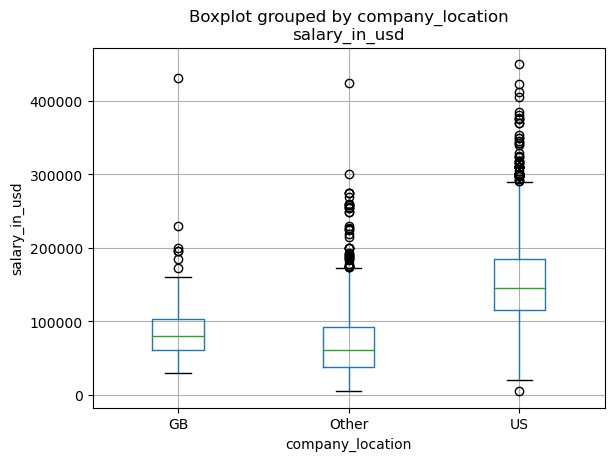

In [12]:
salary_df.boxplot('salary_in_usd', 'company_location')
plt.ylabel('salary_in_usd')
plt.show()

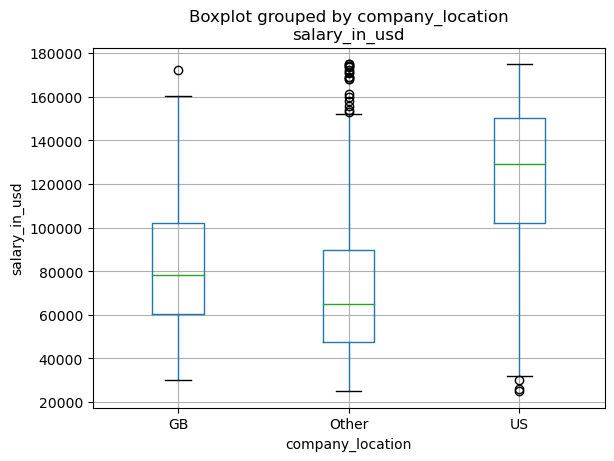

In [13]:
salary_df = salary_df[salary_df['salary_in_usd'] <= 175000]
salary_df = salary_df[salary_df['salary_in_usd'] >= 25000]
salary_df.boxplot('salary_in_usd', 'company_location')
plt.ylabel('salary_in_usd')
plt.show()

In [14]:
# Check and clean job titles. Drop small data points
salary_df['job_title'].value_counts()

Data Engineer                775
Data Scientist               581
Data Analyst                 552
Machine Learning Engineer    177
Analytics Engineer            70
                            ... 
Azure Data Engineer            1
Marketing Data Engineer        1
Compliance Data Analyst        1
Manager Data Management        1
Finance Data Analyst           1
Name: job_title, Length: 82, dtype: int64

In [15]:
job_title_map = clean_categories(salary_df['job_title'].value_counts(), 100)
salary_df['job_title'] = salary_df['job_title'].map(job_title_map)
salary_df['job_title'].value_counts()

Data Engineer                775
Other                        614
Data Scientist               581
Data Analyst                 552
Machine Learning Engineer    177
Name: job_title, dtype: int64

In [16]:
salary_df.head()

,experience_level,job_title,salary_in_usd,remote_ratio,company_location,company_size
0,SE,Other,85847,100,Other,L
3,SE,Data Scientist,175000,100,Other,M
4,SE,Data Scientist,120000,100,Other,M
6,SE,Other,136000,0,US,L
8,SE,Data Scientist,141000,0,Other,M


In [17]:
# Encode object data in dataframe
experience_level = LabelEncoder()
salary_df['experience_level'] = experience_level.fit_transform(salary_df['experience_level'])
salary_df['experience_level'].unique()

array([3, 0, 2, 1])

In [18]:
# employment_type = LabelEncoder()
# salary_df['employment_type'] = employment_type.fit_transform(salary_df['employment_type'])
# salary_df['employment_type'].unique()

In [19]:
job_title = LabelEncoder()
salary_df['job_title'] = job_title.fit_transform(salary_df['job_title'])
salary_df['job_title'].unique()

array([4, 2, 0, 3, 1])

In [20]:
company_location = LabelEncoder()
salary_df['company_location'] = company_location.fit_transform(salary_df['company_location'])
salary_df['company_location'].unique()

array([1, 2, 0])

In [21]:
company_size = LabelEncoder()
salary_df['company_size'] = company_size.fit_transform(salary_df['company_size'])
salary_df['company_size'].unique()

array([0, 1, 2])

In [22]:
# Train model
X = salary_df.drop('salary_in_usd', axis=1)
y = salary_df['salary_in_usd']

In [23]:
# Splitting the dataset into the Training set and Test set (for refactored code - skip for now)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

In [24]:
print(X_train)

      experience_level  job_title  remote_ratio  company_location  \
2977                 2          4           100                 2   
1956                 3          2           100                 2   
1628                 2          3             0                 2   
2302                 3          0             0                 2   
157                  2          0             0                 0   
...                ...        ...           ...               ...   
1369                 3          4             0                 2   
1293                 3          2           100                 2   
1566                 3          0             0                 1   
376                  3          4           100                 2   
1517                 2          0             0                 2   

      company_size  
2977             1  
1956             1  
1628             1  
2302             1  
157              1  
...            ...  
1369             1  
129

In [25]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [26]:
y_pred = regressor.predict(X_test)
training_predictions = regressor.predict(X_train)
testing_predictions = regressor.predict(X_test)

In [27]:
error = np.sqrt(mean_squared_error(y_test , y_pred))
# error = mean_absolute_error(y_test , y_pred)

In [28]:
error

32096.20209240464

In [29]:
X

,experience_level,job_title,remote_ratio,company_location,company_size
0,3,4,100,1,0
3,3,2,100,1,1
4,3,2,100,1,1
6,3,4,0,2,0
8,3,2,0,1,1
...,...,...,...,...,...
3748,2,1,50,1,0
3749,3,4,100,2,0
3751,2,4,100,2,0
3752,0,2,100,2,2


In [30]:
# create application input array for model data
# work_year, experience_level, employment_type, job_title, remote_ratio, company_location, company_size
X = np.array([['SE', 'Data Scientist', '0', 'US', 'L']])
X

array([['SE', 'Data Scientist', '0', 'US', 'L']], dtype='<U14')

In [31]:
X[:, 0] = experience_level.transform(X[:, 0])
X[:, 1] = job_title.transform(X[:, 1])
X[:, 3] = company_location.transform(X[:, 3])
X[:, 4] = company_size.transform(X[:, 4])
X = X.astype('int64')
X

array([[3, 2, 0, 2, 0]])

In [32]:
y_pred = regressor.predict(X)
y_pred

/Users/Philip/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([130321.88734059])

In [33]:
# Create model data map and save to local file for reuse. 
data = {
    "X_train": X_train,
    "X_test": X_test, 
    "y_train": y_train, 
    "y_test": y_test,
    "model": regressor,
    "training_predictions": training_predictions,
    "testing_predictions": testing_predictions,
    "experience_level": experience_level,
    "job_title": job_title,
    "company_location": company_location,
    "company_size": company_size
}

In [34]:
# Set model's file path
# Export model to an HDF5 file
with open('../Resources/salaries_pred_model.pkl', 'wb') as file:
    pickle.dump(data, file)

In [35]:
with open('../Resources/salaries_pred_model.pkl', 'rb') as file:
    model_data = pickle.load(file)

X_train = model_data["X_train"]
X_test = model_data["X_test"]
y_train = model_data["y_train"]
y_test = model_data["y_test"]
regressor_loaded = model_data["model"]
training_predictions = model_data["training_predictions"]
testing_predictions = model_data["testing_predictions"]
experience_level = model_data["experience_level"]
job_title = model_data["job_title"]
company_location = model_data["company_location"]
company_size = model_data["company_size"]


In [36]:
y_pred = regressor_loaded.predict(X)
y_pred

/Users/Philip/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([130321.88734059])

In [37]:
print(regressor_loaded.score(X_test,y_test) * 100, '%')

21.632134055057726 %


In [38]:
# The coefficients
print("Coefficients: \n", regressor_loaded.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, testing_predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_test, testing_predictions))

Coefficients: 
 [10231.77536843  3645.13862808   -38.57149287 30269.10231076
   231.5208723 ]
Mean squared error: 1030166188.76
Coefficient of determination: 0.22


In [39]:
# Define the regressors
regressors = [

    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor()),
    ('KNN', KNeighborsRegressor()),
    ('Decision Tree', DecisionTreeRegressor()),
    ("Linear Regression", LinearRegression()),
    ("Support Vector", SVR()),
    ("Gaussian Process", GaussianProcessRegressor())
    
]

# Create an empty DataFrame to store the metrics
metrics_df = pd.DataFrame(columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Score'])

# Iterate over each regressor
for reg_name, reg in regressors:
    steps = [('MinMax',StandardScaler()),('Regressor', reg)]
    pipeline = Pipeline(steps)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # Calculate the evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = metrics.r2_score(y_test, y_pred)

    new_row = {
        'Model': reg_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2
    }

    metrics_df = pd.concat([metrics_df, pd.DataFrame([new_row])], ignore_index=True)

# Sort the metrics DataFrame by RMSE and R2 Score in ascending order
p_sorted_metrics_df = metrics_df.sort_values(by=['MAE'], ascending=[True])

p_sorted_metrics_df

,Model,MAE,MSE,RMSE,R2 Score
1,Gradient Boosting,24138.804098,9.158425e+08,30262.890334,0.303291
0,Random Forest,24277.296399,9.515642e+08,30847.433820,0.276116
3,Decision Tree,24664.962941,9.862383e+08,31404.431786,0.249739
6,Gaussian Process,24912.725452,1.008013e+09,31749.217100,0.233174
2,KNN,25676.840741,1.078298e+09,32837.446057,0.179706
4,Linear Regression,26218.420627,1.030166e+09,32096.202092,0.216321
5,Support Vector,30540.478361,1.339549e+09,36599.852904,-0.019036
